#### Data Cleaning

In [4]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("Health_Risk_Dataset.csv")

print("First rows:\n", df.head())
print("\nMissing values:\n", df.isnull().sum())

# Handle Missing Values

# For numeric columns → median imputation

num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# For categorical columns → mode imputation

cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Encode categorical variables

from sklearn.preprocessing import LabelEncoder

# Encode 'Consciousness' and 'Risk_Level'

le_consciousness = LabelEncoder()
df['Consciousness'] = le_consciousness.fit_transform(df['Consciousness'])

le_risk = LabelEncoder()
df['Risk_Level'] = le_risk.fit_transform(df['Risk_Level'])

# Drop Patient_ID (not useful for prediction)

df = df.drop(columns=['Patient_ID'])

print("\nData after cleaning:\n", df.head())
print("\nEncoded Risk Levels:", dict(zip(le_risk.classes_, le_risk.transform(le_risk.classes_))))

First rows:
   Patient_ID  Respiratory_Rate  Oxygen_Saturation  O2_Scale  Systolic_BP  \
0      P0522                25                 96         1           97   
1      P0738                28                 92         2          116   
2      P0741                29                 91         1           79   
3      P0661                24                 96         1           95   
4      P0412                20                 96         1           97   

   Heart_Rate  Temperature Consciousness  On_Oxygen Risk_Level  
0         107         37.5             A          0     Medium  
1         151         38.5             P          1       High  
2         135         38.4             A          0       High  
3          92         37.3             A          0     Medium  
4          97         37.4             A          0        Low  

Missing values:
 Patient_ID           0
Respiratory_Rate     0
Oxygen_Saturation    0
O2_Scale             0
Systolic_BP          0
Heart_R

#### Risk Prediction Model

AUC Score: 0.999

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        56
           1       0.96      0.94      0.95        51
           2       0.92      0.98      0.95        61
           3       1.00      0.97      0.98        32

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.97       200
weighted avg       0.97      0.96      0.97       200


Confusion Matrix:
 [[54  0  2  0]
 [ 0 48  3  0]
 [ 0  1 60  0]
 [ 0  1  0 31]]

Sample Results:
      Respiratory_Rate  Oxygen_Saturation  O2_Scale  Systolic_BP  Heart_Rate  \
543                23                 95         1          107          92   
727                20                 94         1          107          80   
9                  18                 98         1          127          72   
876                13                 97         1          119          66   
460                16        

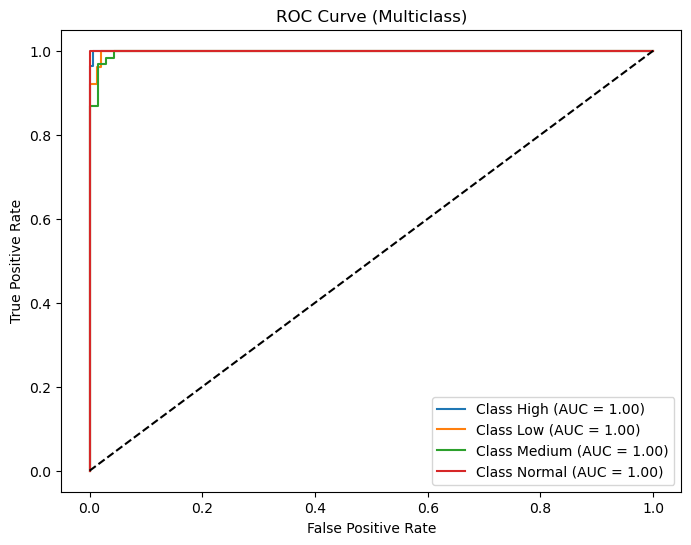

In [ ]:
# Risk Prediction Model

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

# Separate features and target

X = df.drop(columns=["Risk_Level"])
y = df["Risk_Level"]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Gradient Boosting Classifier
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# AUC score (macro-average across classes)
auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr")
print(f"AUC Score: {auc_score:.3f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Risk Categories based on probabilities
# Taking probability of 'High' risk class (encoded with LabelEncoder earlier)
high_risk_index = list(model.classes_).index(le_risk.transform(["High"])[0])
proba_high = y_proba[:, high_risk_index]

# Assign categories manually
risk_categories = pd.cut(proba_high, bins=[-0.01, 0.33, 0.66, 1], labels=["Low", "Medium", "High"])

# Add results to test set
results = X_test.copy()
results["True_Risk"] = le_risk.inverse_transform(y_test)
results["Predicted_Risk"] = le_risk.inverse_transform(y_pred)
results["High_Risk_Prob"] = proba_high
results["Risk_Category"] = risk_categories

print("\nSample Results:\n", results.head())

# Save results
results.to_csv("patient_risk_predictions.csv", index=False)
print("\nSaved risk predictions to patient_risk_predictions.csv")

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}
for i, class_label in enumerate(model.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test == class_label, y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i, class_label in enumerate(model.classes_):
    plt.plot(fpr[i], tpr[i], label=f"Class {le_risk.inverse_transform([class_label])[0]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend()
plt.show()

#### Visualization

AUC Score: 0.999

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        56
           1       0.96      0.94      0.95        51
           2       0.92      0.98      0.95        61
           3       1.00      0.97      0.98        32

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.97       200
weighted avg       0.97      0.96      0.97       200



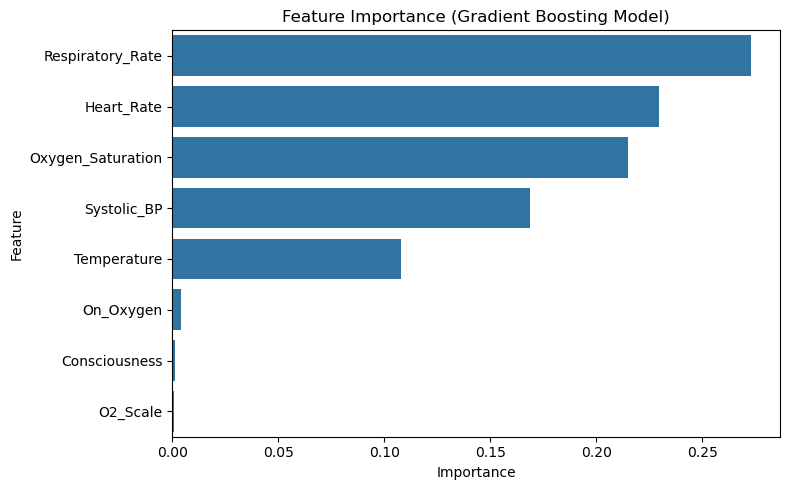

✅ Saved patient_risk_predictions.csv


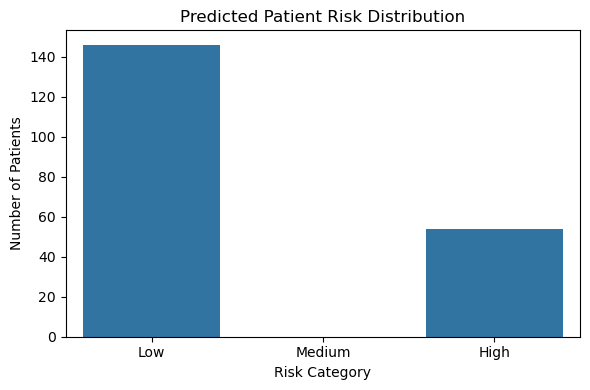

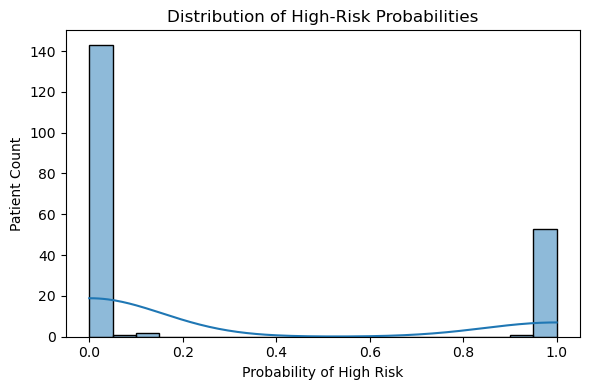

✅ Visualization completed successfully!
📊 Files generated: feature_importance.png, risk_distribution.png, probability_distribution.png


In [8]:
# %% [markdown]
# #### Reporting and Visualization (Final, Error-Free Version)

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ---- Load and preprocess dataset ----
df = pd.read_csv("Health_Risk_Dataset.csv")

# Encode categorical features
le_consciousness = LabelEncoder()
df["Consciousness"] = le_consciousness.fit_transform(df["Consciousness"])

le_risk = LabelEncoder()
df["Risk_Level"] = le_risk.fit_transform(df["Risk_Level"])

if "Patient_ID" in df.columns:
    df = df.drop(columns=["Patient_ID"])

# ---- Split data ----
X = df.drop(columns=["Risk_Level"])
y = df["Risk_Level"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- Train Gradient Boosting Model ----
model = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42
)
model.fit(X_train, y_train)

# ---- Evaluate ----
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba, multi_class="ovr")

print(f"AUC Score: {auc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---- Feature Importance Visualization ----
importances = model.feature_importances_
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp, x="Importance", y="Feature")
plt.title("Feature Importance (Gradient Boosting Model)")
plt.tight_layout()
plt.savefig("feature_importance.png", bbox_inches="tight")
plt.show()

# ---- Risk Category Visualization ----
# Probability of "High" risk (encoded class)
high_index = list(model.classes_).index(le_risk.transform(["High"])[0])
proba_high = y_proba[:, high_index]
risk_category = pd.cut(proba_high, bins=[-0.01, 0.33, 0.66, 1], labels=["Low", "Medium", "High"])

results = X_test.copy()
results["True_Risk"] = le_risk.inverse_transform(y_test)
results["Predicted_Risk"] = le_risk.inverse_transform(y_pred)
results["High_Risk_Prob"] = proba_high
results["Risk_Category"] = risk_category

results.to_csv("patient_risk_predictions.csv", index=False)
print("✅ Saved patient_risk_predictions.csv")

# ---- Plot Risk Category Counts ----
plt.figure(figsize=(6,4))
sns.countplot(x="Risk_Category", data=results, order=["Low", "Medium", "High"])
plt.title("Predicted Patient Risk Distribution")
plt.xlabel("Risk Category")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.savefig("risk_distribution.png", bbox_inches="tight")
plt.show()

# ---- Probability Distribution Plot ----
plt.figure(figsize=(6,4))
sns.histplot(results["High_Risk_Prob"], bins=20, kde=True)
plt.title("Distribution of High-Risk Probabilities")
plt.xlabel("Probability of High Risk")
plt.ylabel("Patient Count")
plt.tight_layout()
plt.savefig("probability_distribution.png", bbox_inches="tight")
plt.show()

print("✅ Visualization completed successfully!")
print("📊 Files generated: feature_importance.png, risk_distribution.png, probability_distribution.png")
